<a href="https://colab.research.google.com/github/kaisarmasum/Quantum-Data-Visualization/blob/main/Quantum_Text_Data_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Quantum Shift: Interactive Text Data Visualization

In [ ]:
!pip install wordcloud

!pip install qiskit[visualization]==1.0.223

In [ ]:
import numpy as np
import math
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def create_vocabulary(sentences):
    vocabulary_set = set()
    for sentence in sentences:
        words = sentence.split()
        vocabulary_set.update(words)
    vocabulary = list(vocabulary_set)
    return vocabulary

def one_hot_encode(word, vocabulary):
    one_hot_vector = [0] * len(vocabulary)
    if word in vocabulary:
        index = vocabulary.index(word)
        one_hot_vector[index] = 1
    return one_hot_vector

def sentence_to_one_hot(sentence, vocabulary):
    one_hot_vectors = []
    for word in sentence.split():
        one_hot_vector = one_hot_encode(word, vocabulary)
        one_hot_vectors.append(one_hot_vector)
    return one_hot_vectors

sentences = ["He hates me", "She loves coding", "Programming is fun"]

vocabulary = create_vocabulary(sentences)

result = []
for sentence in sentences:
    result.append(sentence_to_one_hot(sentence, vocabulary))

In [ ]:
flattened_sentences = [item for sublist in result for item in sublist]
binary_strings = [''.join(map(str, vector)) for vector in flattened_sentences]

print(binary_strings)

['000001000', '000010000', '100000000', '000100000', '000000001', '001000000', '000000100', '000000010', '010000000']


In [ ]:
# Create a dictionary
binary_to_word_dict = dict(zip(binary_strings, vocabulary))
print(binary_to_word_dict)

{'000001000': 'me', '000010000': 'fun', '100000000': 'coding', '000100000': 'She', '000000001': 'hates', '001000000': 'He', '000000100': 'Programming', '000000010': 'is', '010000000': 'loves'}


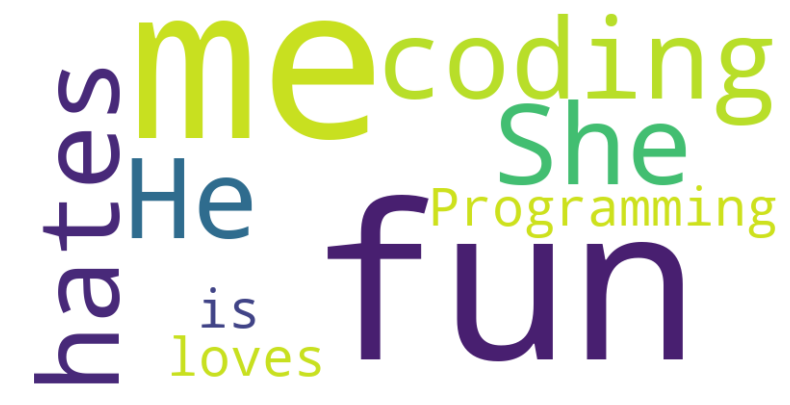

In [ ]:
from wordcloud import WordCloud
word_frequencies = {word: list(binary_to_word_dict.values()).count(word) for word in set(binary_to_word_dict.values())}

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate_from_frequencies(word_frequencies)


plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('words.png')
plt.show()

In [ ]:
df = pd.DataFrame(0, index=binary_to_word_dict.values(), columns=binary_to_word_dict.values())

for word in binary_to_word_dict.values():
    df.loc[word, word] = 1

plt.figure(figsize=(10, 8))

heatmap = sns.heatmap(df, annot=True, cmap='cividis', linewidths=.5)

# Rotate x-axis labels by 45 degrees
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right')

# Rotate y-axis labels by 45 degrees
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=45)

plt.xlabel('Words')
plt.ylabel('Words')
plt.title('Classical Words')
plt.savefig('onehot.png')
# Show the plot
plt.show()

In [ ]:
!pip install qiskit
!pip install qiskit-ibm-runtime
!pip install qiskit-aer

In [ ]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit_ibm_runtime import SamplerV2 as Sampler, QiskitRuntimeService

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Batch

In [ ]:
#service = QiskitRuntimeService(channel="ibm_quantum",token="17b393e56b83c3fcd6f0a0787e66e5bf269523c45a66dd2318940a7a7c2635825db26814f7d6bd5625956bcce5d8795335d1356e3244a6f026e5b7113c901512")
#backend = service.backend("")

In [ ]:
from qiskit.providers.basic_provider import BasicProvider
backend = BasicProvider().get_backend("basic_simulator")

In [ ]:
def grover_oracle(marked_states):
    if not isinstance(marked_states, list):
        marked_states = [marked_states]

    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    for target in marked_states:
        rev_target = target[::-1]
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]

        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc

In [ ]:
oracle = grover_oracle(binary_strings)
oracle.draw( style="iqp")

┌───┐        ┌───┐┌───┐   ┌───┐┌───┐   ┌───┐┌───┐   ┌───┐┌───┐   »
q_0: ──────■─┤ X ├──────■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─»
     ┌───┐ │ ├───┤      │ ├───┤└───┘ │ ├───┤├───┤ │ ├───┤├───┤ │ ├───┤├───┤ │ »
q_1: ┤ X ├─■─┤ X ├──────■─┤ X ├──────■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─»
     ├───┤ │ ├───┤┌───┐ │ ├───┤      │ ├───┤└───┘ │ ├───┤├───┤ │ ├───┤├───┤ │ »
q_2: ┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├──────■─┤ X ├──────■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─»
     ├───┤ │ ├───┤├───┤ │ ├───┤┌───┐ │ ├───┤      │ ├───┤└───┘ │ ├───┤├───┤ │ »
q_3: ┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├──────■─┤ X ├──────■─┤ X ├┤ X ├─■─»
     ├───┤ │ ├───┤├───┤ │ ├───┤├───┤ │ ├───┤┌───┐ │ ├───┤      │ ├───┤└───┘ │ »
q_4: ┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├──────■─┤ X ├──────■─»
     ├───┤ │ ├───┤├───┤ │ ├───┤├───┤ │ ├───┤├───┤ │ ├───┤┌───┐ │ ├───┤      │ »
q_5: ┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├──────■─»
     ├───┤ │ ├───┤├───┤ │ ├───┤├───┤ │ ├───┤├───┤ │ ├───┤├───┤ │ ├───┤┌───┐ │ »
q_6: ┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─»
     ├───┤ │ ├───┤├───┤ │ ├───┤├───┤ │ ├───┤├───┤ │ ├───┤├───┤ │ ├───┤├───┤ │ »
q_7: ┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─»
     ├───┤ │ ├───┤├───┤ │ ├───┤├───┤ │ ├───┤├───┤ │ ├───┤├───┤ │ ├───┤├───┤ │ »
q_8: ┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─»
     └───┘   └───┘└───┘   └───┘└───┘   └───┘└───┘   └───┘└───┘   └───┘└───┘   »
«     ┌───┐┌───┐   ┌───┐        ┌───┐        ┌───┐┌───┐   ┌───┐        ┌───┐»
«q_0: ┤ X ├┤ X ├─■─┤ X ├──────■─┤ X ├──────■─┤ X ├┤ X ├─■─┤ X ├──────■─┤ X ├»
«     ├───┤├───┤ │ ├───┤      │ ├───┤      │ ├───┤├───┤ │ ├───┤      │ ├───┤»
«q_1: ┤ X ├┤ X ├─■─┤ X ├──────■─┤ X ├──────■─┤ X ├┤ X ├─■─┤ X ├──────■─┤ X ├»
«     ├───┤├───┤ │ ├───┤┌───┐ │ ├───┤┌───┐ │ ├───┤├───┤ │ ├───┤┌───┐ │ ├───┤»
«q_2: ┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├»
«     ├───┤├───┤ │ ├───┤├───┤ │ ├───┤├───┤ │ ├───┤├───┤ │ ├───┤├───┤ │ ├───┤»
«q_3: ┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├»
«     ├───┤├───┤ │ ├───┤└───┘ │ └───┘└───┘ │ ├───┤└───┘ │ ├───┤├───┤ │ ├───┤»
«q_4: ┤ X ├┤ X ├─■─┤ X ├──────■────────────■─┤ X ├──────■─┤ X ├┤ X ├─■─┤ X ├»
«     ├───┤└───┘ │ ├───┤┌───┐ │ ┌───┐      │ ├───┤      │ ├───┤└───┘ │ ├───┤»
«q_5: ┤ X ├──────■─┤ X ├┤ X ├─■─┤ X ├──────■─┤ X ├──────■─┤ X ├──────■─┤ X ├»
«     ├───┤      │ └───┘└───┘ │ └───┘      │ ├───┤      │ ├───┤      │ ├───┤»
«q_6: ┤ X ├──────■────────────■────────────■─┤ X ├──────■─┤ X ├──────■─┤ X ├»
«     ├───┤┌───┐ │ ┌───┐┌───┐ │ ┌───┐┌───┐ │ ├───┤      │ └───┘      │ ├───┤»
«q_7: ┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├──────■────────────■─┤ X ├»
«     ├───┤├───┤ │ ├───┤├───┤ │ ├───┤├───┤ │ ├───┤┌───┐ │ ┌───┐┌───┐ │ ├───┤»
«q_8: ┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├»
«     └───┘└───┘   └───┘└───┘   └───┘└───┘   └───┘└───┘   └───┘└───┘   └───┘»
«             ┌───┐
«q_0: ──────■─┤ X ├
«           │ ├───┤
«q_1: ──────■─┤ X ├
«     ┌───┐ │ ├───┤
«q_2: ┤ X ├─■─┤ X ├
«     ├───┤ │ ├───┤
«q_3: ┤ X ├─■─┤ X ├
«     ├───┤ │ ├───┤
«q_4: ┤ X ├─■─┤ X ├
«     └───┘ │ ├───┤
«q_5: ──────■─┤ X ├
«           │ ├───┤
«q_6: ──────■─┤ X ├
«           │ ├───┤
«q_7: ──────■─┤ X ├
«           │ └───┘
«q_8: ──────■──────
«

In [ ]:
grover_op = GroverOperator(oracle)
grover_op.decompose().draw(style="iqp")

global phase: π
                 ┌───┐        ┌───┐┌───┐   ┌───┐┌───┐   ┌───┐┌───┐   ┌───┐┌───┐»
state_0: ──────■─┤ X ├──────■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├»
         ┌───┐ │ ├───┤      │ ├───┤└───┘ │ ├───┤├───┤ │ ├───┤├───┤ │ ├───┤├───┤»
state_1: ┤ X ├─■─┤ X ├──────■─┤ X ├──────■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├»
         ├───┤ │ ├───┤┌───┐ │ ├───┤      │ ├───┤└───┘ │ ├───┤├───┤ │ ├───┤├───┤»
state_2: ┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├──────■─┤ X ├──────■─┤ X ├┤ X ├─■─┤ X ├┤ X ├»
         ├───┤ │ ├───┤├───┤ │ ├───┤┌───┐ │ ├───┤      │ ├───┤└───┘ │ ├───┤├───┤»
state_3: ┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├──────■─┤ X ├──────■─┤ X ├┤ X ├»
         ├───┤ │ ├───┤├───┤ │ ├───┤├───┤ │ ├───┤┌───┐ │ ├───┤      │ ├───┤└───┘»
state_4: ┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├──────■─┤ X ├─────»
         ├───┤ │ ├───┤├───┤ │ ├───┤├───┤ │ ├───┤├───┤ │ ├───┤┌───┐ │ ├───┤     »
state_5: ┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├─────»
         ├───┤ │ ├───┤├───┤ │ ├───┤├───┤ │ ├───┤├───┤ │ ├───┤├───┤ │ ├───┤┌───┐»
state_6: ┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├»
         ├───┤ │ ├───┤├───┤ │ ├───┤├───┤ │ ├───┤├───┤ │ ├───┤├───┤ │ ├───┤├───┤»
state_7: ┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├»
         ├───┤ │ ├───┤├───┤ │ ├───┤├───┤ │ ├───┤├───┤ │ ├───┤├───┤ │ ├───┤├───┤»
state_8: ┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├»
         └───┘   └───┘└───┘   └───┘└───┘   └───┘└───┘   └───┘└───┘   └───┘└───┘»
«            ┌───┐┌───┐   ┌───┐        ┌───┐        ┌───┐┌───┐   ┌───┐        »
«state_0: ─■─┤ X ├┤ X ├─■─┤ X ├──────■─┤ X ├──────■─┤ X ├┤ X ├─■─┤ X ├──────■─»
«          │ ├───┤├───┤ │ ├───┤      │ ├───┤      │ ├───┤├───┤ │ ├───┤      │ »
«state_1: ─■─┤ X ├┤ X ├─■─┤ X ├──────■─┤ X ├──────■─┤ X ├┤ X ├─■─┤ X ├──────■─»
«          │ ├───┤├───┤ │ ├───┤┌───┐ │ ├───┤┌───┐ │ ├───┤├───┤ │ ├───┤┌───┐ │ »
«state_2: ─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─»
«          │ ├───┤├───┤ │ ├───┤├───┤ │ ├───┤├───┤ │ ├───┤├───┤ │ ├───┤├───┤ │ »
«state_3: ─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─»
«          │ ├───┤├───┤ │ ├───┤└───┘ │ └───┘└───┘ │ ├───┤└───┘ │ ├───┤├───┤ │ »
«state_4: ─■─┤ X ├┤ X ├─■─┤ X ├──────■────────────■─┤ X ├──────■─┤ X ├┤ X ├─■─»
«          │ ├───┤└───┘ │ ├───┤┌───┐ │ ┌───┐      │ ├───┤      │ ├───┤└───┘ │ »
«state_5: ─■─┤ X ├──────■─┤ X ├┤ X ├─■─┤ X ├──────■─┤ X ├──────■─┤ X ├──────■─»
«          │ ├───┤      │ └───┘└───┘ │ └───┘      │ ├───┤      │ ├───┤      │ »
«state_6: ─■─┤ X ├──────■────────────■────────────■─┤ X ├──────■─┤ X ├──────■─»
«          │ ├───┤┌───┐ │ ┌───┐┌───┐ │ ┌───┐┌───┐ │ ├───┤      │ └───┘      │ »
«state_7: ─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├──────■────────────■─»
«          │ ├───┤├───┤ │ ├───┤├───┤ │ ├───┤├───┤ │ ├───┤┌───┐ │ ┌───┐┌───┐ │ »
«state_8: ─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├┤ X ├─■─»
«            └───┘└───┘   └───┘└───┘   └───┘└───┘   └───┘└───┘   └───┘└───┘   »
«         ┌───┐        ┌───┐┌───┐┌───┐     ┌───┐┌───┐     
«state_0: ┤ X ├──────■─┤ X ├┤ H ├┤ X ├──■──┤ X ├┤ H ├─────
«         ├───┤      │ ├───┤├───┤├───┤  │  ├───┤├───┤     
«state_1: ┤ X ├──────■─┤ X ├┤ H ├┤ X ├──■──┤ X ├┤ H ├─────
«         ├───┤┌───┐ │ ├───┤├───┤├───┤  │  ├───┤├───┤     
«state_2: ┤ X ├┤ X ├─■─┤ X ├┤ H ├┤ X ├──■──┤ X ├┤ H ├─────
«         ├───┤├───┤ │ ├───┤├───┤├───┤  │  ├───┤├───┤     
«state_3: ┤ X ├┤ X ├─■─┤ X ├┤ H ├┤ X ├──■──┤ X ├┤ H ├─────
«         ├───┤├───┤ │ ├───┤├───┤├───┤  │  ├───┤├───┤     
«state_4: ┤ X ├┤ X ├─■─┤ X ├┤ H ├┤ X ├──■──┤ X ├┤ H ├─────
«         ├───┤└───┘ │ ├───┤├───┤├───┤  │  ├───┤├───┤     
«state_5: ┤ X ├──────■─┤ X ├┤ H ├┤ X ├──■──┤ X ├┤ H ├─────
«         ├───┤      │ ├───┤├───┤├───┤  │  ├───┤├───┤     
«state_6: ┤ X ├──────■─┤ X ├┤ H ├┤ X ├──■──┤ X ├┤ H ├─────
«         ├───┤      │ ├───┤├───┤├───┤  │  ├───┤├───┤     
«state_7: ┤ X ├──────■─┤ X ├┤ H ├┤ X ├──

In [ ]:
optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(binary_strings) / 2**grover_op.num_qubits)))
)

In [ ]:
qc = QuantumCircuit(grover_op.num_qubits)
qc.h(range(grover_op.num_qubits))
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
qc.measure_all()
qc.draw(style="iqp")

┌───┐┌────┐┌────┐┌────┐┌────┐┌────┐ ░ ┌─┐                        
   q_0: ┤ H ├┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├─░─┤M├────────────────────────
        ├───┤│    ││    ││    ││    ││    │ ░ └╥┘┌─┐                     
   q_1: ┤ H ├┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├─░──╫─┤M├─────────────────────
        ├───┤│    ││    ││    ││    ││    │ ░  ║ └╥┘┌─┐                  
   q_2: ┤ H ├┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├─░──╫──╫─┤M├──────────────────
        ├───┤│    ││    ││    ││    ││    │ ░  ║  ║ └╥┘┌─┐               
   q_3: ┤ H ├┤3   ├┤3   ├┤3   ├┤3   ├┤3   ├─░──╫──╫──╫─┤M├───────────────
        ├───┤│    ││    ││    ││    ││    │ ░  ║  ║  ║ └╥┘┌─┐            
   q_4: ┤ H ├┤4 Q ├┤4 Q ├┤4 Q ├┤4 Q ├┤4 Q ├─░──╫──╫──╫──╫─┤M├────────────
        ├───┤│    ││    ││    ││    ││    │ ░  ║  ║  ║  ║ └╥┘┌─┐         
   q_5: ┤ H ├┤5   ├┤5   ├┤5   ├┤5   ├┤5   ├─░──╫──╫──╫──╫──╫─┤M├─────────
        ├───┤│    ││    ││    ││    ││    │ ░  ║  ║  ║  ║  ║ └╥┘┌─┐      
   q_6: ┤ H ├┤6   ├┤6   ├┤6   ├┤6   ├┤6   ├─░──╫──╫──╫──╫──╫──╫─┤M├──────
        ├───┤│    ││    ││    ││    ││    │ ░  ║  ║  ║  ║  ║  ║ └╥┘┌─┐   
   q_7: ┤ H ├┤7   ├┤7   ├┤7   ├┤7   ├┤7   ├─░──╫──╫──╫──╫──╫──╫──╫─┤M├───
        ├───┤│    ││    ││    ││    ││    │ ░  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐
   q_8: ┤ H ├┤8   ├┤8   ├┤8   ├┤8   ├┤8   ├─░──╫──╫──╫──╫──╫──╫──╫──╫─┤M├
        └───┘└────┘└────┘└────┘└────┘└────┘ ░  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘
meas: 9/═══════════════════════════════════════╩══╩══╩══╩══╩══╩══╩══╩══╩═
                                               0  1  2  3  4  5  6  7  8

In [ ]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.primitives.sampler import Sampler
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=1)
circuit_ibm = pm.run(qc)

In [ ]:
with Batch(backend=backend) as batch:
    sampler = Sampler()
    dist = sampler.run(circuit_ibm, skip_transpilation=False, shots=1000).result().quasi_dists[0]
dist.binary_probabilities()

{'000000001': 0.08,
 '000000010': 0.12,
 '000000100': 0.1,
 '000001000': 0.11,
 '000010000': 0.06,
 '000100000': 0.07,
 '001000000': 0.07,
 '001010011': 0.1,
 '001110000': 0.07,
 '010000000': 0.05,
 '011100011': 0.05,
 '100000000': 0.11,
 '101001010': 0.01}

In [ ]:
binary_dict = dist.binary_probabilities()

In [ ]:
binary_dict

{'000000001': 0.08,
 '000000010': 0.12,
 '000000100': 0.1,
 '000001000': 0.11,
 '000010000': 0.06,
 '000100000': 0.07,
 '001000000': 0.07,
 '001010011': 0.1,
 '001110000': 0.07,
 '010000000': 0.05,
 '011100011': 0.05,
 '100000000': 0.11,
 '101001010': 0.01}

In [ ]:
import matplotlib.pyplot as plt

# Given probability distribution
probability_distribution = binary_dict

# Extracting binary strings and corresponding probabilities
binary_strings = list(probability_distribution.keys())
probabilities = list(probability_distribution.values())

# Creating a bar chart
plt.bar(binary_strings, probabilities, color='blue')
plt.xlabel('Binary Strings')
plt.ylabel('Probability')
plt.title('Probability Distribution of Binary Strings')
plt.xticks(rotation=45, ha='right')  # Rotating x-axis labels for better visibility
plt.tight_layout()

# Display the plot
plt.savefig('probability.png')
plt.show()

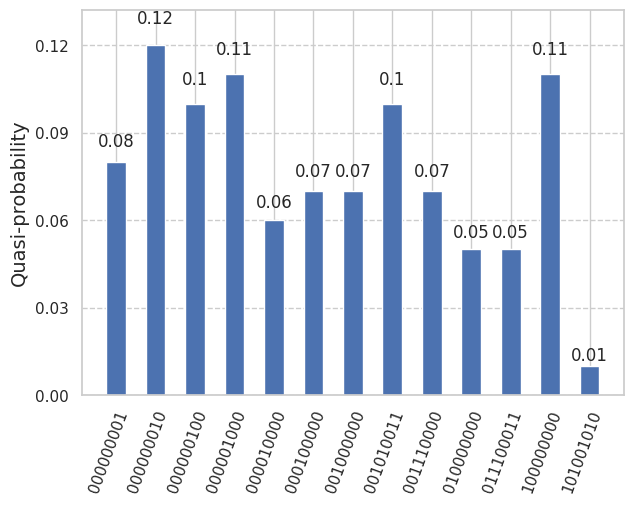

In [ ]:
plot_distribution(binary_dict)

In [ ]:
def get_values_for_present_keys(input_dict, output_dict):
    input_keys = set(input_dict.keys())
    output_keys = set(output_dict.keys())
    common_keys = input_keys.intersection(output_keys)
    values_for_common_keys = {key: input_dict[key] for key in common_keys}
    return values_for_common_keys

In [ ]:
result = get_values_for_present_keys(binary_to_word_dict, binary_dict)
result

{'000100000': 'She',
 '000000100': 'Programming',
 '010000000': 'loves',
 '000001000': 'me',
 '000000010': 'is',
 '000000001': 'hates',
 '000010000': 'fun',
 '100000000': 'coding',
 '001000000': 'He'}

In [ ]:
def visualize_word_cloud(values_dict):
    # Convert values_dict to a frequency dictionary
    frequencies = {word: int(freq * 100) for word, freq in values_dict.items()}

    # Generate a word cloud from the frequencies
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(frequencies)

    # Plot the Word Cloud image
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Input Values')
    plt.show()

In [ ]:
def visualize_word_cloud_bit(values_dict):
    # Count occurrences of each word
    frequencies = {}
    for word, value in values_dict.items():
        if value in frequencies:
            frequencies[word] += 1
        else:
            frequencies[word] = 1

    # Generate WordCloud from frequencies
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(frequencies)

    # Plot the Word Cloud image
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Binary values from Quantum Output')
    plt.savefig('Binary.png')
    plt.show()

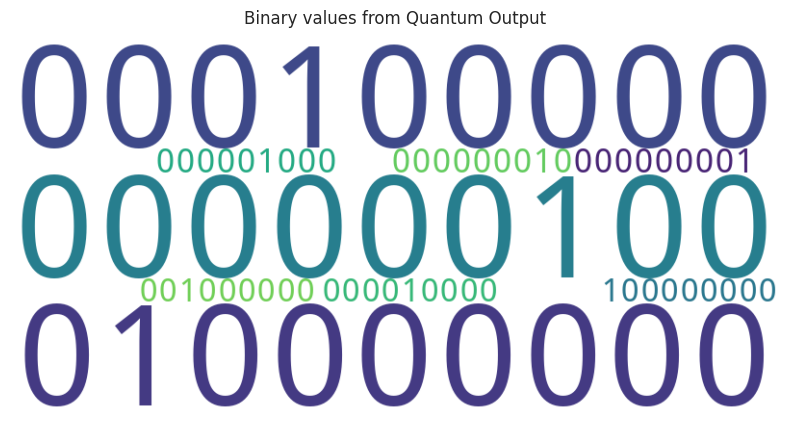

In [ ]:
visualize_word_cloud_bit(result)

In [ ]:
words = []
for i in result.values():
    words.append(i)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

data = binary_dict

word_mapping = {'100000000': 'Programming',
                '000001000': 'loves',
                '001000000': 'coding',
                '000010000': 'He',
                '000000001': 'fun',
                '000100000': 'me',
                '010000000': 'hates',
                '000000010': 'She',
                '000000100': 'is'}

# Sorting data by values
sorted_data = sorted(data.items(), key=lambda x: x[1], reverse=True)

# Extracting binary patterns and their corresponding values
patterns, values = zip(*sorted_data)

# Set seaborn style
sns.set(style="whitegrid")

# Create a bar plot
fig, ax2 = plt.subplots(figsize=(10, 6))

# Plot individual probabilities with aesthetic view
bars = ax2.bar(patterns, values, color='skyblue', edgecolor='black')

# Add marks and lines on top of each bar
for bar, pattern, value in zip(bars, patterns, values):
    ax2.annotate(f'{value:.2f}', xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points", ha='center', va='bottom', fontsize=8, color='black')
    ax2.plot([bar.get_x(), bar.get_x() + bar.get_width()], [bar.get_height(), bar.get_height()],
             color='black', linestyle='-', linewidth=0.5)

# Add words labels at the top of each bar
for bar, pattern in zip(bars, patterns):
    word_label = word_mapping.get(pattern, 'No word')
    ax2.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, word_label, ha='center', va='bottom', fontsize=10)

ax2.set_xlabel('Quantum Output', fontsize=12)
ax2.set_ylabel('Probability', fontsize=12)
ax2.set_title('Words from Binary Patterns', fontsize=14)

# Rotate x-axis labels
ax2.set_xticklabels(patterns, rotation=45, ha='right', fontsize=10)

# Remove grid
ax2.grid(False)

# Remove legend
ax2.legend().remove()

# Adjust margins
plt.margins(y=0.1)

# Add horizontal line at y=0
ax2.axhline(0, color='black', linewidth=0.5)

# Add background color
ax2.set_facecolor('#f5f5f5')

plt.tight_layout()
plt.savefig('output.png', dpi=300)  # Save the plot with higher resolution
plt.show()

In [ ]:
import plotly.graph_objects as go

# Define the data
words_data = binary_dict

word_mapping = {'100000000': 'Programming',
                '000001000': 'loves',
                '001000000': 'coding',
                '000010000': 'He',
                '000000001': 'fun',
                '000100000': 'me',
                '010000000': 'hates',
                '000000010': 'She',
                '000000100': 'is'}

# Map word codes to actual words
words = [word_mapping.get(code, 'No Word') for code in words_data.keys()]
frequencies = list(words_data.values())

# Create the bar chart
fig = go.Figure([go.Bar(x=words, y=frequencies)])

# Update layout for better readability
fig.update_layout(title_text='Word Frequencies',
                  xaxis_title='Words',
                  yaxis_title='Frequency')

fig.show()

In [ ]:
import plotly.graph_objects as go

# Define the data
words_data = binary_dict

word_mapping = {'100000000': 'Programming',
                '000001000': 'loves',
                '001000000': 'coding',
                '000010000': 'He',
                '000000001': 'fun',
                '000100000': 'me',
                '010000000': 'hates',
                '000000010': 'She',
                '000000100': 'is'}

# Map word codes to actual words
words = []
for code in words_data.keys():
    if code in word_mapping:
        words.append(word_mapping[code])
    else:
        words.append('Unknown')

frequencies = list(words_data.values())

# Create the pie chart
fig = go.Figure(data=[go.Pie(labels=words, values=frequencies)])

# Update layout for better readability and reduced size
fig.update_layout(height=400, width=500)

# Show the interactive graph
fig.show()


In [ ]:
import plotly.graph_objects as go

# Define the data
known_words_frequency = sum(words_data.get(code, 0) for code in word_mapping)
unknown_words_frequency = 1 - known_words_frequency

# Create the pie chart
fig = go.Figure(data=[go.Pie(labels=['Known Words', 'Unknown Words'],
                             values=[known_words_frequency, unknown_words_frequency])])

# Update layout for better readability and reduced size
fig.update_layout(height=400, width=500)

# Show the interactive graph
fig.show()

In [ ]:
sorted_words_data = sorted(words_data.items(), key=lambda x: x[1], reverse=True)

correlated_words = []
for word_key, _ in sorted_words_data:
    if word_key in word_mapping:
        correlated_words.append(word_mapping[word_key])

print("Correlated Words based on Probabilities:")
print(correlated_words)

Correlated Words based on Probabilities:
['loves', 'He', 'She', 'hate', 'me', 'Programming', 'fun', 'coding', 'is']


In [ ]:
from graphviz import Digraph

# Given dictionaries
binary_dict = {
    '000000001': 0.1,
    '000000010': 0.11,
    '000000100': 0.09,
    '000001000': 0.09,
    '000010000': 0.14,
    '000100000': 0.12,
    '001000000': 0.11,
    '010000000': 0.14,
    '100000000': 0.08
}

result = {
    '000000001': 'fun',
    '000001000': 'me',
    '000000100': 'loves',
    '000000010': 'is',
    '000010000': 'He',
    '010000000': 'hates',
    '000100000': 'coding',
    '100000000': 'Programming',
    '001000000': 'She'
}

# Create a new Digraph
dot = Digraph(comment='Sentence Tree')

# Add nodes to the graph
for binary, prob in binary_dict.items():
    word = result.get(binary, binary)
    dot.node(binary, f'{word}\n({prob})')

# Add edges based on binary string
for binary in binary_dict.keys():
    for i in range(len(binary)):
        if binary[i] == '1':
            parent = binary[:i] + '0' + binary[i+1:]
            dot.edge(parent, binary)

# Save the graph
custom_graph_path = dot.render('sentence_tree', format='png', view=True)

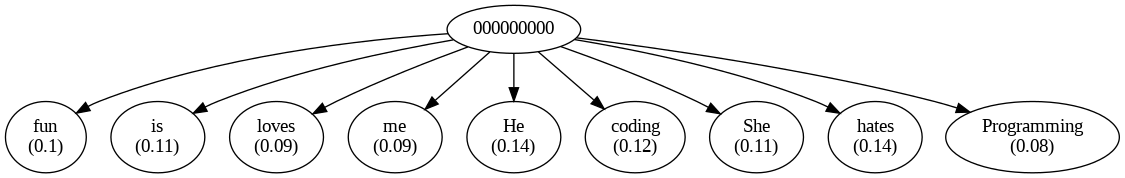

In [ ]:
from IPython.display import Image
Image(filename=custom_graph_path)

In [ ]:
# Given dictionaries
binary_dict = {
    '000000001': 0.1,
    '000000010': 0.11,
    '000000100': 0.09,
    '000001000': 0.09,
    '000010000': 0.14,
    '000100000': 0.12,
    '001000000': 0.11,
    '010000000': 0.14,
    '100000000': 0.08
}

result = {
    '000000001': 'fun',
    '000001000': 'me',
    '000000100': 'loves',
    '000000010': 'is',
    '000010000': 'He',
    '010000000': 'hates',
    '000100000': 'coding',
    '100000000': 'Programming',
    '001000000': 'She'
}

# Step 1: Extract sequences and their probabilities
sequences = list(binary_dict.keys())
probabilities = list(binary_dict.values())

# Step 2: Extract corresponding words
words = [result[seq] for seq in sequences]

# Step 3: Form pairs of words and calculate their probabilities
pairs_probabilities = {}

for i in range(len(words)):
    for j in range(i + 1, len(words)):
        pair = (words[i], words[j])
        pair_probability = probabilities[i] * probabilities[j]
        pairs_probabilities[pair] = pair_probability

# Step 4: Sort pairs by their probabilities (optional)
sorted_pairs = sorted(pairs_probabilities.items(), key=lambda item: item[1], reverse=True)

# Display the word pairs and their probabilities
for pair, prob in sorted_pairs:
    print(f"Pair: {pair}, Probability: {prob:.5f}")

Pair: ('He', 'hates'), Probability: 0.01960
Pair: ('He', 'coding'), Probability: 0.01680
Pair: ('coding', 'hates'), Probability: 0.01680
Pair: ('is', 'He'), Probability: 0.01540
Pair: ('is', 'hates'), Probability: 0.01540
Pair: ('He', 'She'), Probability: 0.01540
Pair: ('She', 'hates'), Probability: 0.01540
Pair: ('fun', 'He'), Probability: 0.01400
Pair: ('fun', 'hates'), Probability: 0.01400
Pair: ('is', 'coding'), Probability: 0.01320
Pair: ('coding', 'She'), Probability: 0.01320
Pair: ('loves', 'He'), Probability: 0.01260
Pair: ('loves', 'hates'), Probability: 0.01260
Pair: ('me', 'He'), Probability: 0.01260
Pair: ('me', 'hates'), Probability: 0.01260
Pair: ('is', 'She'), Probability: 0.01210
Pair: ('fun', 'coding'), Probability: 0.01200
Pair: ('He', 'Programming'), Probability: 0.01120
Pair: ('hates', 'Programming'), Probability: 0.01120
Pair: ('fun', 'is'), Probability: 0.01100
Pair: ('fun', 'She'), Probability: 0.01100
Pair: ('loves', 'coding'), Probability: 0.01080
Pair: ('me', 

In [ ]:
!pip install graphviz

In [ ]:
import graphviz

def create_pairs_probabilities():
    """
    Create a list of word pairs with their associated probabilities.
    """
    return [
        (('He', 'hates'), 0.01960),
        (('He', 'coding'), 0.01680),
        (('coding', 'hates'), 0.01680),
        (('is', 'He'), 0.01540),
        (('is', 'hates'), 0.01540),
        (('He', 'She'), 0.01540),
        (('She', 'hates'), 0.01540),
        (('fun', 'He'), 0.01400),
        (('fun', 'hates'), 0.01400),
        (('is', 'coding'), 0.01320),
        (('coding', 'She'), 0.01320),
        (('loves', 'He'), 0.01260),
        (('loves', 'hates'), 0.01260),
        (('me', 'He'), 0.01260),
        (('me', 'hates'), 0.01260),
        (('is', 'She'), 0.01210),
        (('fun', 'coding'), 0.01200),
        (('He', 'Programming'), 0.01120),
        (('hates', 'Programming'), 0.01120),
        (('fun', 'is'), 0.01100),
        (('fun', 'She'), 0.01100),
        (('loves', 'coding'), 0.01080),
        (('me', 'coding'), 0.01080),
        (('is', 'loves'), 0.00990),
        (('is', 'me'), 0.00990),
        (('loves', 'She'), 0.00990),
        (('me', 'She'), 0.00990),
        (('coding', 'Programming'), 0.00960),
        (('fun', 'loves'), 0.00900),
        (('fun', 'me'), 0.00900),
        (('is', 'Programming'), 0.00880),
        (('She', 'Programming'), 0.00880),
        (('loves', 'me'), 0.00810),
        (('fun', 'Programming'), 0.00800),
        (('loves', 'Programming'), 0.00720),
        (('me', 'Programming'), 0.00720)
    ]

def create_undirected_graph(pairs_probabilities):
    """
    Create an undirected graph from the given pairs and their probabilities.
    """
    dot = graphviz.Graph()  # Initialize an undirected graph

    # Define a list of colors to use for the nodes
    colors = ['red', 'blue', 'green', 'yellow', 'cyan', 'magenta', 'orange', 'purple', 'pink']

    # Add nodes and edges to the graph
    nodes = set()
    for (node1, node2), prob in pairs_probabilities:
        nodes.add(node1)
        nodes.add(node2)

    # Assign colors to nodes
    node_colors = {node: colors[i % len(colors)] for i, node in enumerate(nodes)}

    # Add nodes with colors and edges with probabilities to the graph
    for (node1, node2), prob in pairs_probabilities:
        dot.node(node1, style='filled', fillcolor=node_colors[node1])  # Add node1 with color
        dot.node(node2, style='filled', fillcolor=node_colors[node2])  # Add node2 with color
        dot.edge(node1, node2, label=f'{prob:.5f}')  # Add an edge with a label

    return dot

def save_and_render_graph(dot, filename='word_pairs_tree'):
    """
    Save and render the graph to a file.
    """
    dot.render(filename, format='png', view=True)  # Save as PNG and open the image

def main():
    """
    Main function to create and visualize the tree based on word pairs and probabilities.
    """
    pairs_probabilities = create_pairs_probabilities()  # Step 1: Create pairs and probabilities
    dot = create_undirected_graph(pairs_probabilities)  # Step 2: Create an undirected graph
    save_and_render_graph(dot)  # Step 3: Save and render the graph

# Run the main function
if __name__ == "__main__":
    main()

In [ ]:
from IPython.display import Image
Image(filename='word_pairs_tree.png')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Given data
data = [(('He', 'hates'), 0.01960), (('He', 'coding'), 0.01680), (('coding', 'hates'), 0.01680),
        (('is', 'He'), 0.01540), (('is', 'hates'), 0.01540), (('He', 'She'), 0.01540),
        (('She', 'hates'), 0.01540), (('fun', 'He'), 0.01400), (('fun', 'hates'), 0.01400),
        (('is', 'coding'), 0.01320), (('coding', 'She'), 0.01320), (('loves', 'He'), 0.01260),
        (('loves', 'hates'), 0.01260), (('me', 'He'), 0.01260), (('me', 'hates'), 0.01260),
        (('is', 'She'), 0.01210), (('fun', 'coding'), 0.01200), (('He', 'Programming'), 0.01120),
        (('hates', 'Programming'), 0.01120), (('fun', 'is'), 0.01100), (('fun', 'She'), 0.01100),
        (('loves', 'coding'), 0.01080), (('me', 'coding'), 0.01080), (('is', 'loves'), 0.00990),
        (('is', 'me'), 0.00990), (('loves', 'She'), 0.00990), (('me', 'She'), 0.00990),
        (('coding', 'Programming'), 0.00960), (('fun', 'loves'), 0.00900), (('fun', 'me'), 0.00900),
        (('is', 'Programming'), 0.00880), (('She', 'Programming'), 0.00880), (('loves', 'me'), 0.00810),
        (('fun', 'Programming'), 0.00800), (('loves', 'Programming'), 0.00720), (('me', 'Programming'), 0.00720)]

# Construct co-occurrence matrix
words = sorted(set(word_pair[0] for word_pair, _ in data) | set(word_pair[1] for word_pair, _ in data))
word_index = {word: i for i, word in enumerate(words)}
co_occurrence_matrix = np.zeros((len(words), len(words)))
for word_pair, strength in data:
    word1, word2 = word_pair
    co_occurrence_matrix[word_index[word1]][word_index[word2]] = strength

# Display co-occurrence matrix
plt.figure(figsize=(10, 8))
plt.imshow(co_occurrence_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Strength of Association')
plt.xticks(np.arange(len(words)), words, rotation=45)
plt.yticks(np.arange(len(words)), words)
plt.title('Co-occurrence Matrix')
plt.tight_layout()
plt.show()

# Calculate PMI
total_pairs = len(data)
word_counts = {}
for word_pair, strength in data:
    for word in word_pair:
        word_counts[word] = word_counts.get(word, 0) + 1

pmi_matrix = np.zeros((len(words), len(words)))
for word_pair, strength in data:
    word1, word2 = word_pair
    pmi = strength / (word_counts[word1] * word_counts[word2]) * total_pairs
    pmi_matrix[word_index[word1]][word_index[word2]] = pmi


In [ ]:
# Display PMI matrix (Pointwise Mutual Information)
plt.figure(figsize=(10, 8))
plt.imshow(pmi_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='PMI')
plt.xticks(np.arange(len(words)), words, rotation=45)
plt.yticks(np.arange(len(words)), words)
plt.title('Pointwise Mutual Information (PMI) Matrix')
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

# Given data
data = [(('He', 'hates'), 0.01960), (('He', 'coding'), 0.01680), (('coding', 'hates'), 0.01680),
        (('is', 'He'), 0.01540), (('is', 'hates'), 0.01540), (('He', 'She'), 0.01540),
        (('She', 'hates'), 0.01540), (('fun', 'He'), 0.01400), (('fun', 'hates'), 0.01400),
        (('is', 'coding'), 0.01320), (('coding', 'She'), 0.01320), (('loves', 'He'), 0.01260),
        (('loves', 'hates'), 0.01260), (('me', 'He'), 0.01260), (('me', 'hates'), 0.01260),
        (('is', 'She'), 0.01210), (('fun', 'coding'), 0.01200), (('He', 'Programming'), 0.01120),
        (('hates', 'Programming'), 0.01120), (('fun', 'is'), 0.01100), (('fun', 'She'), 0.01100),
        (('loves', 'coding'), 0.01080), (('me', 'coding'), 0.01080), (('is', 'loves'), 0.00990),
        (('is', 'me'), 0.00990), (('loves', 'She'), 0.00990), (('me', 'She'), 0.00990),
        (('coding', 'Programming'), 0.00960), (('fun', 'loves'), 0.00900), (('fun', 'me'), 0.00900),
        (('is', 'Programming'), 0.00880), (('She', 'Programming'), 0.00880), (('loves', 'me'), 0.00810),
        (('fun', 'Programming'), 0.00800), (('loves', 'Programming'), 0.00720), (('me', 'Programming'), 0.00720)]

# Construct co-occurrence matrix
words = sorted(set(word_pair[0] for word_pair, _ in data) | set(word_pair[1] for word_pair, _ in data))
word_index = {word: i for i, word in enumerate(words)}
co_occurrence_matrix = np.zeros((len(words), len(words)))
for word_pair, strength in data:
    word1, word2 = word_pair
    co_occurrence_matrix[word_index[word1]][word_index[word2]] = strength

# Compute word embeddings using Singular Value Decomposition (SVD)
svd = TruncatedSVD(n_components=9)  # Adjust the number of components as needed
word_embeddings = svd.fit_transform(co_occurrence_matrix)

# Calculate contextual similarity using cosine similarity between word embeddings
contextual_similarity = cosine_similarity(word_embeddings)

# Print the contextual similarity matrix
print("Contextual Similarity Matrix:")
print(contextual_similarity)

Contextual Similarity Matrix:
[[1.         0.         0.70373155 0.85188866 0.72312403 0.34914862
  0.77107975 0.80908187 0.85332019]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.70373155 0.         1.         0.82608395 0.5088852  0.49613894
  0.54263315 0.56937644 0.60050834]
 [0.85188866 0.         0.82608395 1.         0.61602116 0.40985242
  0.6568741  0.68924767 0.72693379]
 [0.72312403 0.         0.5088852  0.61602116 1.         0.25247776
  0.93780705 0.89375879 0.84742403]
 [0.34914862 0.         0.49613894 0.40985242 0.25247776 1.
  0.26922144 0.28248982 0.29793557]
 [0.77107975 0.         0.54263315 0.6568741  0.93780705 0.26922144
  1.         0.95303057 0.90362301]
 [0.80908187 0.         0.56937644 0.68924767 0.89375879 0.28248982
  0.95303057 1.         0.94815742]
 [0.85332019 0.         0.60050834 0.72693379 0.84742403 0.29793557
  0.90362301 0.94815742 1.        ]]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'contextual_similarity' contains the computed contextual similarity matrix

# Display contextual similarity matrix with a different colormap
plt.figure(figsize=(10, 8))
plt.imshow(contextual_similarity, cmap='coolwarm', interpolation='nearest')  # Using 'coolwarm' colormap
plt.colorbar(label='Cosine Similarity')
plt.xticks(np.arange(len(words)), words, rotation=45)
plt.yticks(np.arange(len(words)), words)
plt.title('Contextual Similarity Matrix')
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Given data
data = [(('He', 'hates'), 0.01960), (('He', 'coding'), 0.01680), (('coding', 'hates'), 0.01680),
        (('is', 'He'), 0.01540), (('is', 'hates'), 0.01540), (('He', 'She'), 0.01540),
        (('She', 'hates'), 0.01540), (('fun', 'He'), 0.01400), (('fun', 'hates'), 0.01400),
        (('is', 'coding'), 0.01320), (('coding', 'She'), 0.01320), (('loves', 'He'), 0.01260),
        (('loves', 'hates'), 0.01260), (('me', 'He'), 0.01260), (('me', 'hates'), 0.01260),
        (('is', 'She'), 0.01210), (('fun', 'coding'), 0.01200), (('He', 'Programming'), 0.01120),
        (('hates', 'Programming'), 0.01120), (('fun', 'is'), 0.01100), (('fun', 'She'), 0.01100),
        (('loves', 'coding'), 0.01080), (('me', 'coding'), 0.01080), (('is', 'loves'), 0.00990),
        (('is', 'me'), 0.00990), (('loves', 'She'), 0.00990), (('me', 'She'), 0.00990),
        (('coding', 'Programming'), 0.00960), (('fun', 'loves'), 0.00900), (('fun', 'me'), 0.00900),
        (('is', 'Programming'), 0.00880), (('She', 'Programming'), 0.00880), (('loves', 'me'), 0.00810),
        (('fun', 'Programming'), 0.00800), (('loves', 'Programming'), 0.00720), (('me', 'Programming'), 0.00720)]

# Convert data into documents
documents = [' '.join(pair) for pair, _ in data]

# Apply TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(documents)

# Perform Singular Value Decomposition (SVD)
svd = TruncatedSVD(n_components=9)  # Adjust the number of components as needed
lsa_matrix = svd.fit_transform(tfidf_matrix)

# Compute semantic similarity using cosine similarity
semantic_similarity_matrix = cosine_similarity(lsa_matrix)

# Print the semantic similarity matrix
print("Semantic Similarity Matrix:")
print(semantic_similarity_matrix)

Semantic Similarity Matrix:
[[ 1.00000000e+00  5.00000000e-01  5.00000000e-01 ... -1.42384193e-16
  -9.68833980e-17 -1.97445459e-16]
 [ 5.00000000e-01  1.00000000e+00  5.00000000e-01 ... -9.64466607e-17
   1.26616456e-16 -9.55467403e-17]
 [ 5.00000000e-01  5.00000000e-01  1.00000000e+00 ... -1.35770304e-16
  -1.22873540e-16 -8.48769479e-17]
 ...
 [-1.42384193e-16 -9.64466607e-17 -1.35770304e-16 ...  1.00000000e+00
   5.00000000e-01  5.00000000e-01]
 [-9.68833980e-17  1.26616456e-16 -1.22873540e-16 ...  5.00000000e-01
   1.00000000e+00  5.00000000e-01]
 [-1.97445459e-16 -9.55467403e-17 -8.48769479e-17 ...  5.00000000e-01
   5.00000000e-01  1.00000000e+00]]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Semantic similarity matrix (replace this with your computed matrix)
semantic_similarity_matrix = np.random.rand(9, 9)

# Display semantic similarity matrix
plt.figure(figsize=(10, 8))
plt.imshow(semantic_similarity_matrix, cmap='cividis', interpolation='nearest')
plt.colorbar(label='Semantic Similarity')
plt.xticks(np.arange(len(words)), words, rotation=45)
plt.yticks(np.arange(len(words)), words)
plt.title('Semantic Similarity Matrix')
plt.tight_layout()
plt.show()